# CompositionDE - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *CompositionDE* package to analyze changes in cell composition data.

The package is intended to be used with data coming from single-cell RNA-seq experiments, however there are no 
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.


In [4]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import arviz as az
import anndata as ad
import warnings

from scdcdm.util import data_generation as gen
from scdcdm.util import comp_ana as mod
from scdcdm.util import result_classes as res
from scdcdm.util import cell_composition_data as dat

warnings.filterwarnings("ignore")

### Data preparation

In [3]:
# Load data

cell_counts = pd.read_csv("C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\compositionalDiff-johannes_tests_2\\data\\haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each. 
To use the models in *SCDCdm*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object. 

For this example, we want to look at how the Salmonella infection influences the cell composition.

In [7]:
# Convert data to anndata object

# Filter out salmonella data
salm_indices = [0, 1, 2, 3, 8, 9]
salm_df = cell_counts.iloc[salm_indices, :]

data_salm = dat.from_pandas(salm_df, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_salm.obs["Condition"] = data_salm.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_salm.X)
print(data_salm.obs)


Transforming to str index.


[[ 36.  59. 136.  36. 239. 125. 191.  18.]
 [  5.  46.  23.  20.  50.  11.  40.   5.]
 [ 45.  98. 188. 124. 250. 155. 365.  33.]
 [ 26. 221. 198.  36. 131. 130. 196.   4.]
 [ 37. 332. 113.  59.  90.  47. 132.  10.]
 [ 32. 373. 116.  67. 117.  65. 168.  12.]]
       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


### Model setup and inference

We can now create the model and run inference on it. 
The `formula` parameter can process R-style formulas.
The baseline index of `None` specifies the model without baseline specification, a specific baseline index is set by its numerical value.


In [8]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", baseline_index=None)

In [9]:
# Run MCMC
sim_results = model_salm.sample_hmc()
sim_results.summary()


MCMC sampling finished. (139.651 sec)
Acceptance rate: 53.6%
Compositional Analysis summary:
Intercepts:
                       Final Parameter  HPD 3%  HPD 97%     SD  \
Cell Type                                                        
Endocrine                        1.097   0.359    1.819  0.394   
Enterocyte                       2.325   1.738    2.915  0.313   
Enterocyte.Progenitor            2.525   1.901    3.093  0.318   
Goblet                           1.674   1.061    2.320  0.341   
Stem                             2.707   2.155    3.296  0.306   
TA                               2.106   1.510    2.748  0.331   
TA.Early                         2.866   2.259    3.433  0.311   
Tuft                             0.390  -0.452    1.120  0.431   

                       Expected Sample  
Cell Type                               
Endocrine                    34.124522  
Enterocyte                  116.514560  
Enterocyte.Progenitor       142.311205  
Goblet                       

The "Final parameter" column for the Effects tells us, which cell types change significantly. 
If the value is zero, no significant effect was detected. 
For a value other than zero, a significant increase or decrease, depending on the sign, was detected.

In this example, we see only a significant decrease of Enterocytes, while all other cell types are unaffected by the disease.


### Diagnostics and plotting

For further analysis, the results object supports all plotting and diagnosis functions of [arviz](https://github.com/arviz-devs/arviz).


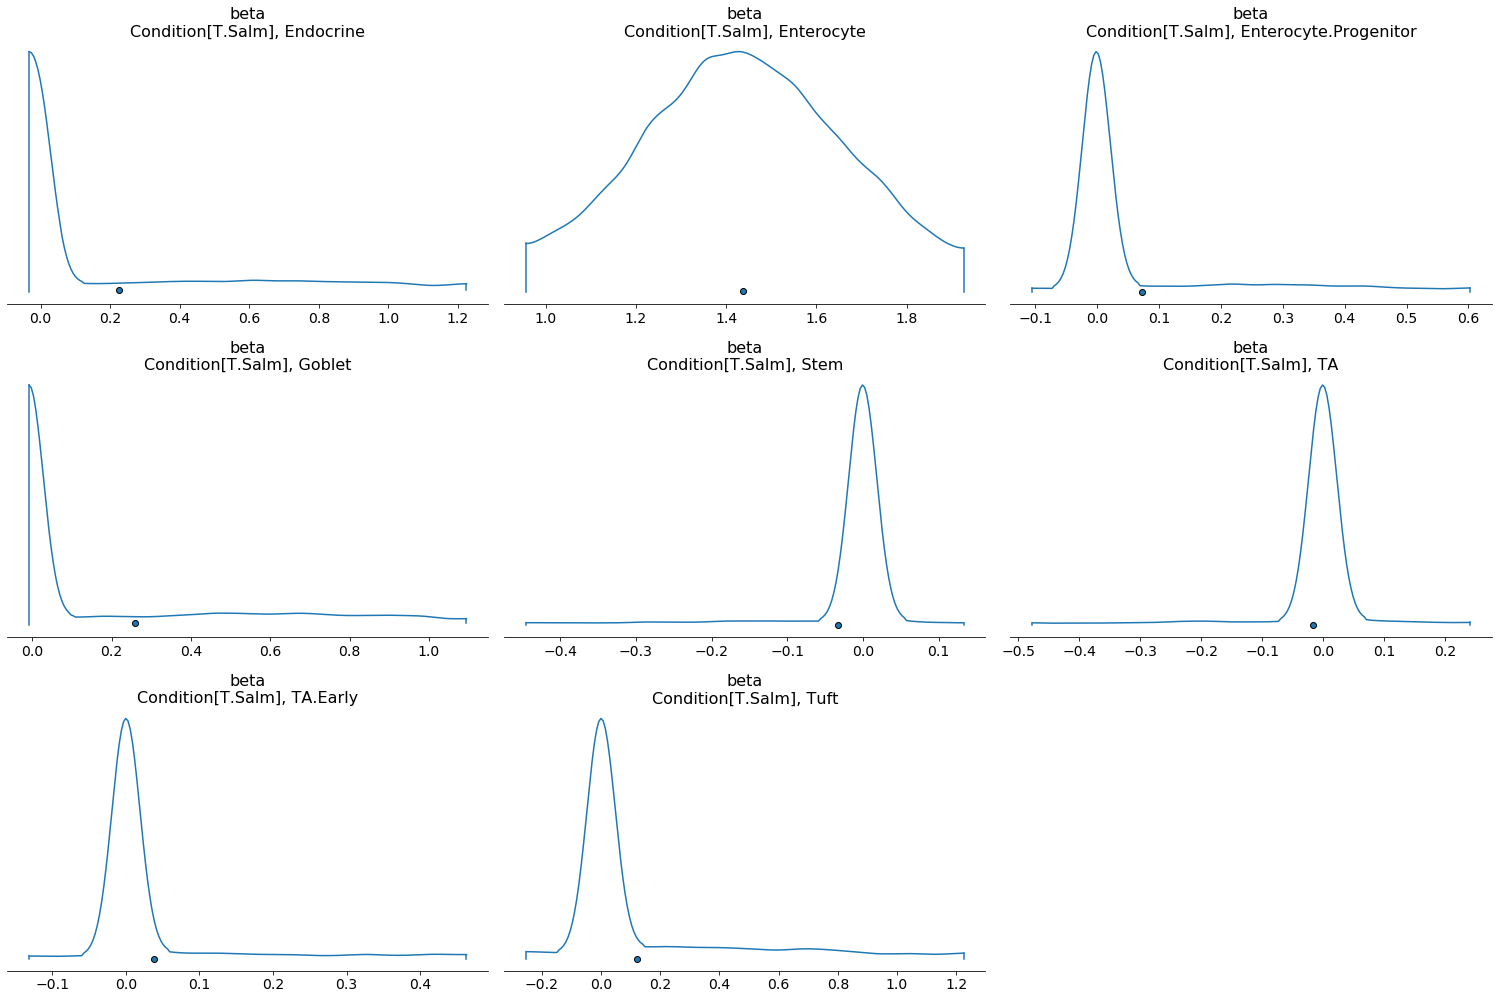

In [12]:
az.plot_density(sim_results, var_names="beta")
plt.show()